[View in Colaboratory](https://colab.research.google.com/github/stoiver/anuga-clinic-2018/blob/master/install_anuga.ipynb)

# CSDMS ANUGA Clinic 2018

## Install ANUGA

Run the following cell to install ANUGA on Colaboratory. 

Wait until you see the comment *(5) Ready to go* before proceeding to subsequent commands. 
The install should take less than a minute.

In [15]:
print "(1) Install netcdf nose via pip"
!pip -q install netCDF4 nose  > /dev/null 2>&1 
print "(2) Install gdal via apt-get"
!apt-get -q -y install python-gdal gdal-bin  > /dev/null 2>&1 

print "(3) Download anuga_core github repository"
!git clone --quiet https://github.com/GeoscienceAustralia/anuga_core.git > /dev/null 2>&1  
print "(4) Install anuga"
import os
os.chdir('anuga_core')
!python setup.py --quiet install  > /dev/null 2>&1 
os.chdir('../')
print "(5) Ready to go"

(1) Install netcdf nose via pip
(2) Install gdal via apt-get
(3) Download anuga_core github repository
(4) Install anuga
(5) Ready to go


## Import ANUGA and other libraries into notebook

Allows us access to `anuga` and inline plotting. Also we have a work around to ensure we don't lose output after the inport of `netcdf'.

In [0]:
import sys
stdout = sys.stdout

import anuga
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# NetCDF changes stdout to the terminal
# This resets it
reload(sys)
sys.stdout = stdout

## Create an ANUGA domain

A `domain` is the core object which contains the mesh and the quantities for the particular problem. Here we create a simple rectangular domain. We set the name to `channel1` which will be used when storing the simulation output to a `sww` file called `channel1.sww`.

In [0]:
domain = anuga.rectangular_cross_domain(40, 20, len1=20.0, len2=10.0)
domain.set_name('channel1')

Let's look at the mesh.

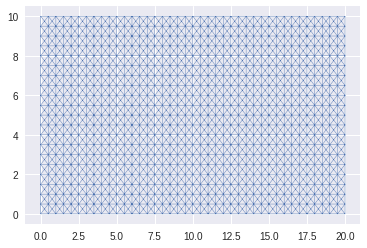

In [18]:
import matplotlib.tri as tri
nodes = domain.nodes
triangles = domain.triangles

triang = tri.Triangulation(nodes[:,0], nodes[:,1], triangles)

plt.triplot(nodes[:,0], nodes[:,1], triangles, linewidth = 0.4);

## Setup Initial Conditions

We have to setup the values of various quantities associated with the domain. In particular we need to setup the `elevation` the elevation of the bed or the bathymetry. In this case we will do this using a function. 

In [0]:
def topography(x, y):

    z = -x/10

    N = len(x)
    
    minx = np.floor(np.max(x)/4)
    stepx1 = np.min(x[(x >= minx)])
    stepx2 = np.min(x[(x > stepx1 + 0.25)])
    
    minx = np.floor(np.max(x)/2)
    stepx3 = np.min(x[(x >= minx)])
    stepx4 = np.min(x[(x > stepx3 + 0.25)])
    
    minx = np.floor(3*np.max(x)/4)
    stepx5 = np.min(x[(x >= minx)])
    stepx6 = np.min(x[(x > stepx5 + 0.25)])
    
    dist = 0.4 * (np.max(y) - np.min(y))
    
    for i in range(N):
        if stepx1 <= x[i] <= stepx2:
            if (y[i] < dist):
                z[i] += 2
                
        if stepx3 <= x[i] <= stepx4:
            if (y[i] > np.max(y) - dist):
                z[i] += 2
                
        if stepx5 <= x[i] <= stepx6:
            if (y[i] < dist):
                z[i] += 2
            
    return z

### Set Quantities

Now we set the `elevation`, `stage` and `friction` using the `domain.set_quantity` function. 

In [0]:
domain.set_quantity('elevation', topography, location='centroids') # Use function for elevation
domain.set_quantity('friction', 0.01, location='centroids')        # Constant friction 
domain.set_quantity('stage', expression='elevation', location='centroids') # Dry Bed 

### View Elevation

Let's use the `matplotlib` function `tripcolor` to plot the `elevation` quantitiy.  We access the `elevation` quantity using `domain.quantities['elevation']`. 

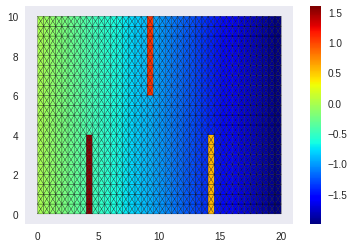

In [20]:
elev = domain.quantities['elevation'].centroid_values
depth = domain.quantities['height'].centroid_values

plt.tripcolor(nodes[:,0], nodes[:,1], triangles, 
              facecolors = elev, 
              edgecolors='k', 
              cmap='jet')
plt.colorbar();


## Setup Boundary Conditions

The rectangular domain has 4 tagged boundaries, left, top, right and bottom. We need to set boundary conditons for each of these tagged boundaries. We can set Dirichlet type BC with specified values of stage, and x and y "momentum". Another common BC is `Reflective_boundary` which mimic a wall. 

In [0]:
Bi = anuga.Dirichlet_boundary([0.4, 0, 0])         # Inflow
Bo = anuga.Dirichlet_boundary([-2, 0, 0])          # Inflow
Br = anuga.Reflective_boundary(domain)             # Solid reflective wall

domain.set_boundary({'left': Bi, 'right': Bo, 'top': Br, 'bottom': Br})

## Run the Evolution

We evolve using a `for` statement, which evolves the quantities using the shallow water wave solver. The calculation `yields` every `yieldstep` seconds, up to a given `duration`.

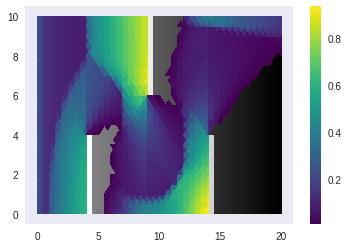

Time = 15.0000, delta t in [0.01401606, 0.01510256], steps=346 (21s)


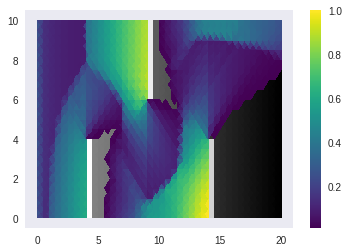

Time = 20.0000, delta t in [0.01356452, 0.01401486], steps=363 (1s)


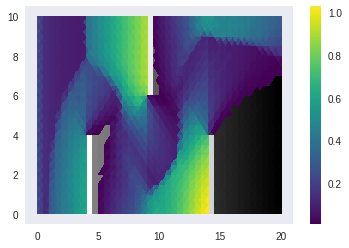

Time = 25.0000, delta t in [0.01304530, 0.01356421], steps=377 (1s)


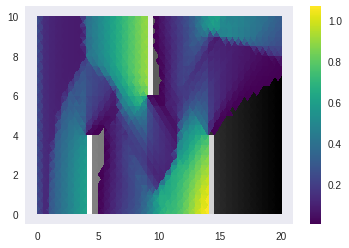

Time = 30.0000, delta t in [0.01273881, 0.01305885], steps=388 (1s)


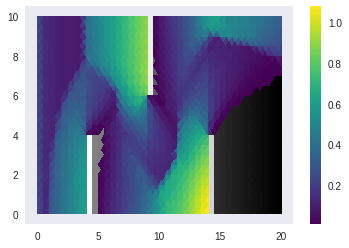

Time = 35.0000, delta t in [0.01258548, 0.01273877], steps=396 (1s)


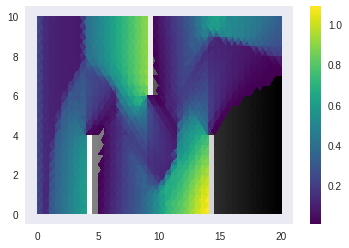

Time = 40.0000, delta t in [0.01251472, 0.01259362], steps=399 (1s)


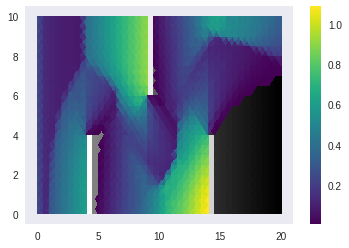

Time = 45.0000, delta t in [0.01246233, 0.01251932], steps=401 (1s)


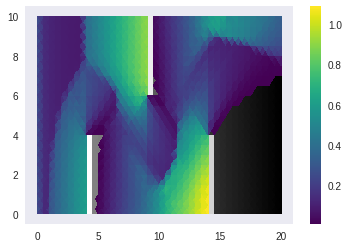

Time = 50.0000, delta t in [0.01244496, 0.01247454], steps=402 (1s)


In [24]:
for t in domain.evolve(yieldstep=5, duration=40):
  
    plt.figure()

    triang.set_mask(depth>0.01)
    plt.tripcolor(triang, 
              facecolors = elev,
              cmap='Greys_r')
    
    triang.set_mask(depth<0.01)
    plt.tripcolor(triang, 
              facecolors = depth,
              cmap='viridis')

    plt.colorbar()
    plt.show()
    
    domain.print_timestepping_statistics()
    

  